<div style="background-color: #eee3d3">
<h1> 3-missing_value_imputation.ipynb </h1>
</div>

# Missing value imputation with Python

---

### The purpose of this notebook is to use different methods to fill the missing values in our peak table :

- __Univariate__ feature imputation
    - __zero__ (or __one__ or any other constant value to avoid further analytical problems)
    - __mean__
    - __median__
    - __mode__ (most frequent)
    - __minimum__
    - __half minimum__
- __Multivariate__ feature imputation
    - __MICE__ (inspired by the R <code>MICE</code> package)
- __KNN imputation__


These methods come from the scikitlearn documentation : [cf. doc scikitlearn](https://scikit-learn.org/stable/modules/impute.html#marking-imputed-values)

One type of imputation algorithm is __univariate__, which imputes values in the i-th feature dimension __using only non-missing values in that feature dimension__ (e.g. <code>impute.SimpleImputer</code>). By contrast, __multivariate__ imputation algorithms __use the entire set of available feature dimensions__ to estimate the missing values (e.g. <code>impute.IterativeImputer</code>).

---

### The scikitlearn <code>IterativeImputer</code> is still experimental, so we will also use directly the R <code>MICE</code> package ([documentation](https://www.rdocumentation.org/packages/mice/versions/3.13.0/topics/mice)) in the R script <code>3.2-missing_value_imputation_MICE</code> (in this directory)

---

# Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import numpy as np
import sklearn
import math

import os

In [2]:
import re
pwd = ! pwd
pwd = re.sub('notebooks', '', pwd[0])
print(f'Working directory : {pwd}')

import sys
sys.path.append(pwd + 'bin/')

from missing_value_imputation_functions import *

Working directory : /home/jovyan/work/


In [170]:
# Tune the visual settings for figures in seaborn
sns.set_context(
    "notebook", font_scale=1.2, rc={"axes.titlesize": 15}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 12, 8

sns.set_theme(style="darkgrid")

# Import data

In [3]:
# path_peakTable = input('Enter absolute path to the peak table csv file : ')
# /home/vincentm/MLnotebooks/metabopipeline_notebooks/data/peakTable/original_peak_table/peakTable_HILIC_POS.csv
path_peakTable = pwd + 'data/peakTable/original_peak_table/peakTable_HILIC_POS_remove_corr.csv'

In [4]:
peakTable = pd.read_csv(path_peakTable, sep=',', decimal='.', na_values='NA')
peakTable.head()

,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,variable_3,variable_5,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,19.761786,14.635833,...,13.194216,12.885181,NaN,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,LivCan_154,Non-case,82,NaN,No,41____41046868,41____41046868,41046868-s2#C,19.735279,15.193396,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,NaN,12.208084
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,19.116076,15.446714,...,12.618229,12.485436,11.709115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LivCan_268,Non-case,427,NaN,No,41____41089214,41____41089214,41089214-s1#B,19.376875,15.460525,...,12.720631,12.564338,NaN,13.397322,NaN,NaN,13.086805,NaN,11.605353,12.319119
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,19.555938,14.515536,...,12.564943,12.344968,12.127879,NaN,NaN,NaN,NaN,12.349830,11.926237,NaN


In [5]:
peakTable.shape

(186, 345)

In [286]:
metadata = peakTable.iloc[:, ['variable' not in col for col in peakTable.columns]]
metadata

,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C
1,LivCan_154,Non-case,82,NaN,No,41____41046868,41____41046868,41046868-s2#C
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B
3,LivCan_268,Non-case,427,NaN,No,41____41089214,41____41089214,41089214-s1#B
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B
...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,NaN,No,32____3208004E,32____32253231,32253231-s3#C
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B
183,LivCan_376,Non-case,383,NaN,No,22____22281701,22____22281701,22281701-s1#B
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C


In [6]:
X = peakTable.iloc[:, ['variable' in col for col in peakTable.columns]]
X.head()

,variable_3,variable_5,variable_6,variable_8,variable_10,variable_11,variable_14,variable_22,variable_23,variable_25,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,19.761786,14.635833,22.185582,12.615143,15.580604,15.881437,17.500899,12.792893,16.805604,16.805842,...,13.194216,12.885181,NaN,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,19.735279,15.193396,20.831414,NaN,15.145423,14.034654,17.953780,NaN,15.907714,14.977232,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,NaN,12.208084
2,19.116076,15.446714,22.152604,NaN,14.628890,15.316772,17.404715,12.786407,15.947176,16.238502,...,12.618229,12.485436,11.709115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19.376875,15.460525,22.169389,12.720767,15.937169,15.967749,15.836957,NaN,16.371211,17.052231,...,12.720631,12.564338,NaN,13.397322,NaN,NaN,13.086805,NaN,11.605353,12.319119
4,19.555938,14.515536,22.150249,12.314019,14.950203,15.294906,16.610171,12.214057,16.171763,16.107590,...,12.564943,12.344968,12.127879,NaN,NaN,NaN,NaN,12.349830,11.926237,NaN


In [7]:
X.shape

(186, 337)

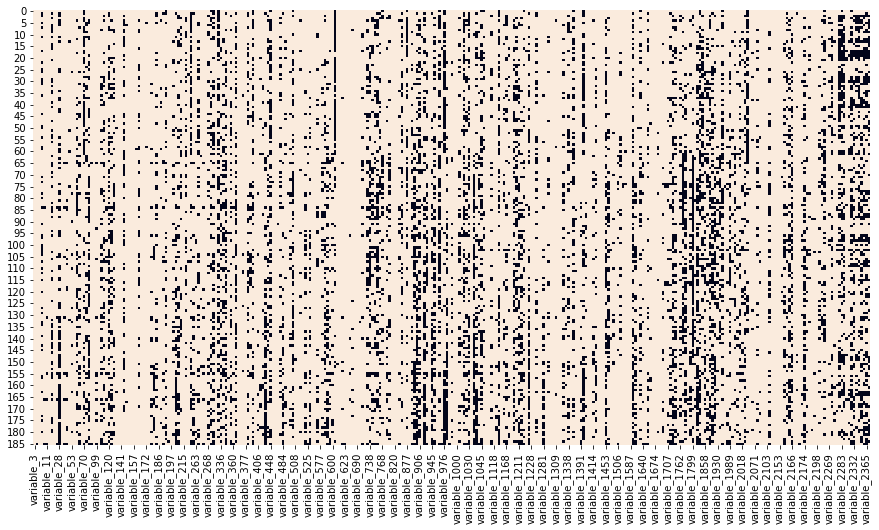

In [8]:
plt.figure(figsize=(15,8))
sns.heatmap(X.notna(), cbar=False);

The dark points indicate a missing value in the peak table

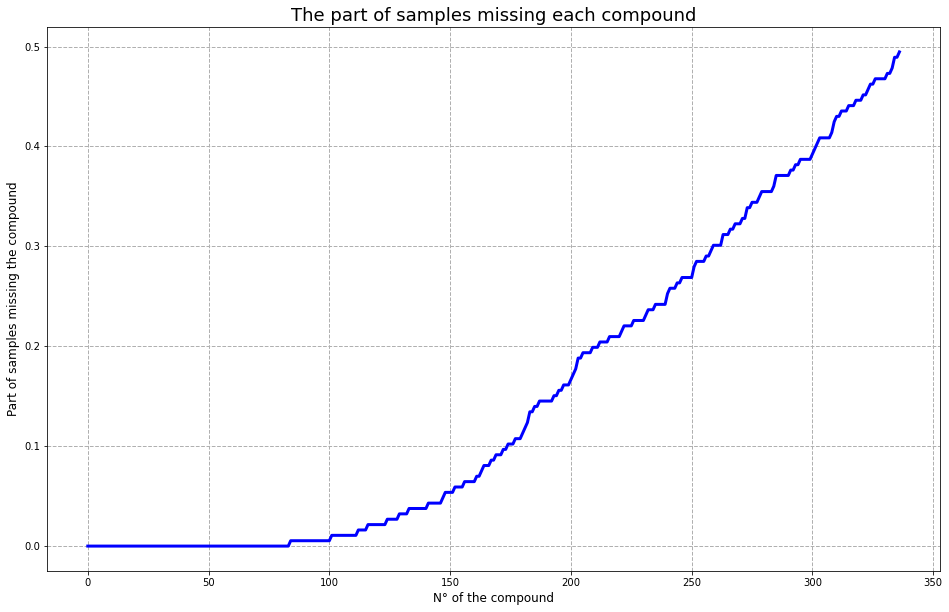

In [9]:
plt.figure(figsize=(16,10))
plt.plot((X.isna().sum() / X.shape[0]).sort_values().values, color='b', linewidth=3)
plt.xlabel('N° of the compound', fontsize=12)
plt.ylabel('Part of samples missing the compound', fontsize=12)
plt.title('The part of samples missing each compound', fontsize=18)
plt.grid(linestyle='--', linewidth=1)
plt.show()

# Path to save imputed peak tables

In [10]:
# path_peakTable_imputed = input('Enter absolute path to save the imputed peak tables as csv files : ')
# /home/vincentm/MLnotebooks/metabopipeline_notebooks/data/peakTable/original_peak_table/peakTable_HILIC_POS.csv
path_peakTable_imputed = pwd + 'data/peakTable/imputed_peak_tables/'

# Univariate feature imputation

## Constant imputation (with whatever constant value passed as argument)

All missing values in the peak table will be replaced by the constant value you pass as parameter.

In [11]:
X_const_0 = const_imputer(X)
X_const_0.to_csv(path_peakTable_imputed + 'X_const_0.csv', index = False, header=True)

In [12]:
X_const_1 = const_imputer(X, 1)
X_const_1.to_csv(path_peakTable_imputed + 'X_const_1.csv', index = False, header=True)

## Mean imputation

For each feature, the missing values are imputed by the mean value of the non-missing values in that feature.

In [13]:
X_mean = mean_imputer(X)
X_mean.to_csv(path_peakTable_imputed + 'X_mean.csv', index = False, header=True)

## Median imputation

For each feature, the missing values are imputed by the median value of the non-missing values in that feature.

In [14]:
X_median = median_imputer(X)
X_median.to_csv(path_peakTable_imputed + 'X_median.csv', index = False, header=True)

In [116]:
path_peakTable_imputed

'/home/jovyan/work/data/peakTable/imputed_peak_tables/'

## Mode imputation (most frequent)

For each feature, the missing values are imputed by the most frequent value (rounded at 1.e-2) of the non-missing values in that feature.

In [119]:
X_mode = mode_imputer(X)
X_mode.to_csv(path_peakTable_imputed + 'X_mode.csv', index = False, header=True)

## Imputation with minimum value of the feature

For each feature, the missing values are imputed by the minimum value of the non-missing values in that feature.

In [118]:
X_min = min_imputer(X)
X_min.to_csv(path_peakTable_imputed + 'X_min.csv', index = False, header=True)

### imputation with half minimum value of the feature

For each feature, the missing values are imputed by the half of the minimum value of the non-missing values in that feature.

In [117]:
X_half_min = half_min_imputer(X)
X_half_min.to_csv(path_peakTable_imputed + 'X_half_min.csv', index = False, header=True)

In [ ]:
const_imputer(X)
const_imputer(X, 1)
mean_imputer(X)
median_imputer(X)
mode_imputer(X)
min_imputer(X)
half_min_imputer(X)

# Multivariate feature imputation

[cf. doc scikitlearn IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)

<code>IterativeImputer</code> was inspired by the R MICE package (Multivariate Imputation by Chained Equations).

On this page ([link](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html)) are presented the different possible estimators that can be applied with <code>IterativeImputer</code> :
- <code>BayesianRidge</code> : regularized linear regression
- <code>DecisionTreeRegressor</code> : non-linear regression
- <code>ExtraTreesRegressor</code> : similar to missForest in R
- <code>KNeighborsRegressor</code> : comparable to other KNN imputation approaches


In [18]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [19]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]

In [20]:
for estimator in estimators:
    
    X_python_MICE = python_MICE_imputer(X, estimator)
    
    X_python_MICE.to_csv(path_peakTable_imputed + 'X_python_MICE_' + str(estimator).split('(')[0] + '.csv', index = False, header=True)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 4.4 seconds -----


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 4.1 seconds -----


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 36.5 seconds -----


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 4.2 seconds -----


## Nearest neighbors imputation

According to scikit-learn documentation (https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation), "Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed."

We let the possibility for the user to impute the values along the two axis with the parameter 'by' :
- by='samples' (default) : the missing value for a specific feature in a sample is imputed using the values of that feature in the n_neighbors samples which have a non-missing value for that feature
- by='feature' : the missing value for a specific feature in a sample is imputed using the values of the n_neighbors features in that sample which have a non-missing value for that sample

In [21]:
X_KNN_features = KNN_imputer(X, by='features')
X_KNN_features.columns = X.columns
X_KNN_features.to_csv(path_peakTable_imputed + 'X_KNN_features.csv', index=False, header=True)

In [22]:
X_KNN_samples = KNN_imputer(X, by='samples')
X_KNN_samples.columns = X.columns
X_KNN_samples.to_csv(path_peakTable_imputed + 'X_KNN_samples.csv', index=False, header=True)

---
# Missing value imputation using R MICE package

Here is a link where the [MICE algorithm is explained](https://cran.r-project.org/web/packages/miceRanger/vignettes/miceAlgorithm.html).

The MICE (Multivariate Imputation by Chained Equations) algorithm is a multivariate method to impute missing values. Each missing value is imputed using a separate model with the other variables in the dataset. Iterations should be run until it appears that convergence has been met. The computational time can be huge, thus we proceed in four steps :
- using the <code>quickpred</code> function ([documentation](https://cran.r-project.org/web/packages/mice/mice.pdf#Rfn.quickpred.1)), we create a squared (column number of the peak table) binary matrix (<code>predictorMatrix</code>), in which $\mathcal{M}_{i,j} = 1$ if we can use the variable $j$ to impute the missing values of the variable $i$, $\mathcal{M}_{i,j} = 0$ otherwise. With this step, only the variables which have a given minimum correlation value can be used to impute the missing values, thus reducing the computational time.
- using the <code>mice</code> function ([documentation](https://cran.r-project.org/web/packages/mice/mice.pdf#Rfn.mice.1)), we actually run the missing value imputation. The built-in imputation methods are listed in the documentation. As we have numerical values in our peak table, we will only implement the following methods in the R script :
    - __Mean__ (method = 'mean')
    - __Simple random sampling__ (method = 'sample')
    - __Classification and regression trees__ (method = 'cart')
    - __Regression imputation__ (classified into two different versions: deterministic and stochastic regression imputation) :
        - __Bayesian linear regression__ (method = "norm")
        - __Deterministic regression imputation__ (method = "norm.predict") :
            - replaces missing values with the exact prediction of the regression model. Random variation (i.e. an error term) around the regression slope is not considered. Imputed values are therefore often too precise and lead to an overestimation of the correlation between X and Y.
        - __Stochastic regression imputation__ (method = "norm.nob") :
            - was developed in order to solve this issue of deterministic regression imputation. Stochastic regression imputation adds a random error term to the predicted value and is therefore able to reproduce the correlation of X and Y more appropriately.
    - __Predictive mean matching__ (method = "pmm") :
        - Overcome disadvantages of regression imputation, implausible values (e.g. negative incomes) and problems with heteroscedastic data

- using the <code>merge_imputations</code> method, we merge the multiple imputed dataframes into one single dataframe (mean of the multiple dataframes)
- using the <code>write.csv</code> method, we export the imputed data into a separate csv file
---

In [23]:
%load_ext rpy2.ipython

In [24]:
%%R

library(mice, warn.conflicts=FALSE)
library(sjmisc, warn.conflicts=FALSE)

In [25]:
# peakTable in the Python namespace
peakTable.head()

,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,variable_3,variable_5,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,19.761786,14.635833,...,13.194216,12.885181,NaN,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,LivCan_154,Non-case,82,NaN,No,41____41046868,41____41046868,41046868-s2#C,19.735279,15.193396,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,NaN,12.208084
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,19.116076,15.446714,...,12.618229,12.485436,11.709115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LivCan_268,Non-case,427,NaN,No,41____41089214,41____41089214,41089214-s1#B,19.376875,15.460525,...,12.720631,12.564338,NaN,13.397322,NaN,NaN,13.086805,NaN,11.605353,12.319119
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,19.555938,14.515536,...,12.564943,12.344968,12.127879,NaN,NaN,NaN,NaN,12.349830,11.926237,NaN


In [26]:
# pass peakTable to the R namespace
%R -i peakTable
%R head(peakTable)

,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,variable_3,variable_5,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,19.761786,14.635833,...,13.194216,12.885181,NaN,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,LivCan_154,Non-case,82,None,No,41____41046868,41____41046868,41046868-s2#C,19.735279,15.193396,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,NaN,12.208084
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,19.116076,15.446714,...,12.618229,12.485436,11.709115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LivCan_268,Non-case,427,None,No,41____41089214,41____41089214,41089214-s1#B,19.376875,15.460525,...,12.720631,12.564338,NaN,13.397322,NaN,NaN,13.086805,NaN,11.605353,12.319119
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,19.555938,14.515536,...,12.564943,12.344968,12.127879,NaN,NaN,NaN,NaN,12.349830,11.926237,NaN
5,LivCan_300,Non-case,376,None,No,21____21104136,21____21104136,21104136-s1#B,19.377437,14.913215,...,13.205960,12.637834,11.881096,13.667759,NaN,NaN,NaN,12.553141,NaN,NaN


In [27]:
# X in the Python namespace
X.head()

,variable_3,variable_5,variable_6,variable_8,variable_10,variable_11,variable_14,variable_22,variable_23,variable_25,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,19.761786,14.635833,22.185582,12.615143,15.580604,15.881437,17.500899,12.792893,16.805604,16.805842,...,13.194216,12.885181,NaN,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,19.735279,15.193396,20.831414,NaN,15.145423,14.034654,17.953780,NaN,15.907714,14.977232,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,NaN,12.208084
2,19.116076,15.446714,22.152604,NaN,14.628890,15.316772,17.404715,12.786407,15.947176,16.238502,...,12.618229,12.485436,11.709115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19.376875,15.460525,22.169389,12.720767,15.937169,15.967749,15.836957,NaN,16.371211,17.052231,...,12.720631,12.564338,NaN,13.397322,NaN,NaN,13.086805,NaN,11.605353,12.319119
4,19.555938,14.515536,22.150249,12.314019,14.950203,15.294906,16.610171,12.214057,16.171763,16.107590,...,12.564943,12.344968,12.127879,NaN,NaN,NaN,NaN,12.349830,11.926237,NaN


In [28]:
# pass X to the R namespace
%R -i X
%R head(X)

,variable_3,variable_5,variable_6,variable_8,variable_10,variable_11,variable_14,variable_22,variable_23,variable_25,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,19.761786,14.635833,22.185582,12.615143,15.580604,15.881437,17.500899,12.792893,16.805604,16.805842,...,13.194216,12.885181,NaN,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,19.735279,15.193396,20.831414,NaN,15.145423,14.034654,17.953780,NaN,15.907714,14.977232,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,NaN,12.208084
2,19.116076,15.446714,22.152604,NaN,14.628890,15.316772,17.404715,12.786407,15.947176,16.238502,...,12.618229,12.485436,11.709115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19.376875,15.460525,22.169389,12.720767,15.937169,15.967749,15.836957,NaN,16.371211,17.052231,...,12.720631,12.564338,NaN,13.397322,NaN,NaN,13.086805,NaN,11.605353,12.319119
4,19.555938,14.515536,22.150249,12.314019,14.950203,15.294906,16.610171,12.214057,16.171763,16.107590,...,12.564943,12.344968,12.127879,NaN,NaN,NaN,NaN,12.349830,11.926237,NaN
5,19.377437,14.913215,22.198844,NaN,14.850260,15.221202,15.810536,13.419177,15.894322,16.119570,...,13.205960,12.637834,11.881096,13.667759,NaN,NaN,NaN,12.553141,NaN,NaN


In [29]:
# path_peakTable_imputed in the Python namespace
path_peakTable_imputed

'/home/jovyan/work/data/peakTable/imputed_peak_tables/'

In [30]:
# pass path_peakTable_imputed to the R namespace
%R -i path_peakTable_imputed
%R cat(path_peakTable_imputed)

/home/jovyan/work/data/peakTable/imputed_peak_tables/

In [31]:
# Compute predictor matrix with X to test if it successes
%R predictorMatrix <- quickpred(X, mincor=0.5, minpuc=0.1, method='pearson')
%R predictorMatrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

'/home/jovyan/work/data/peakTable/imputed_peak_tables/'

In [32]:
%%R

impute_with_MICE <- function(X, list_methods){
    
    # Compute predictor matrix
    predictorMatrix <- quickpred(X, mincor = 0.5, minpuc = 0.1, method = 'pearson')
    
    for (method in list_methods){

        cat(paste(rep('-', 100), collapse=''), '\n')
        cat(paste(c(rep('-', (100 - (nchar(method) + 2)) %/% 2), ' ', method, ' ', rep('-', (100 - (nchar(method) + 2) + 1) %/% 2)), collapse=''), '\n')
        cat('...Computing...\n')
        cat('...............\n')
        
        start_time <- Sys.time()

        invisible(capture.output(imp <- mice(X, method = method, m = 5, maxit = 5, predictorMatrix = predictorMatrix, seed=1234, remove.collinear=FALSE))) # Impute data
        X_imp_merged <- merge_imputations(X, imp) # return data frame with imputed variables
        
        X_imp_merged_full <- cbind(X_imp_merged, X[, names(colSums(is.na(X))[colSums(is.na(X)) == 0])])
        X_imp_merged_full <- X_imp_merged_full[,names(X)]
        
        filename <- paste(path_peakTable_imputed, 'X_R_MICE_', gsub('\\.', '_', method), '.csv', sep='')
        write.csv(X_imp_merged_full, filename, row.names = FALSE)
        
        x <- Sys.time() - start_time
        cat(round(x, digits=2), 'seconds\n')
        cat(paste(rep('-', 100), collapse=''), '\n')
        cat('\n\n')
        
    }
    
}

In [33]:
# Set list of methods for R MICE imputation
%R list_methods <- c('mean', 'sample', 'pmm', 'cart', 'norm', 'norm.nob', 'norm.predict')
%R cat(list_methods)

mean sample pmm cart norm norm.nob norm.predict

In [222]:
%%R

impute_with_MICE <- function(X, method){
    
    # Compute predictor matrix
    predictorMatrix <- quickpred(X, mincor = 0.5, minpuc = 0.1, method = 'pearson')
    
    
    cat(paste(rep('-', 100), collapse=''), '\n')
    cat(paste(c(rep('-', (100 - (nchar(method) + 2)) %/% 2), ' ', method, ' ', rep('-', (100 - (nchar(method) + 2) + 1) %/% 2)), collapse=''), '\n')
    cat('...Computing...\n')
    cat('...............\n')

    start_time <- Sys.time()

    invisible(capture.output(imp <- mice(X, method = method, m = 5, maxit = 5, predictorMatrix = predictorMatrix, seed=1234, remove.collinear=FALSE))) # Impute data
    X_imp_merged <- merge_imputations(X, imp) # return data frame with imputed variables

    X_imp_merged_full <- cbind(X_imp_merged, X[, names(colSums(is.na(X))[colSums(is.na(X)) == 0])])
    X_imp_merged_full <- X_imp_merged_full[,names(X)]

    #filename <- paste(path_peakTable_imputed, 'X_R_MICE_', gsub('\\.', '_', method), '.csv', sep='')
    #write.csv(X_imp_merged_full, filename, row.names = FALSE)

    x <- Sys.time() - start_time
    cat(round(x, digits=2), 'seconds\n')
    cat(paste(rep('-', 100), collapse=''), '\n')
    cat('\n\n')

    return(X_imp_merged_full)
    
    
}

In [223]:
# Set list of methods for R MICE imputation
%R list_methods <- c('mean', 'sample', 'pmm', 'cart', 'norm', 'norm.nob', 'norm.predict')
%R cat(list_methods)

mean sample pmm cart norm norm.nob norm.predict

In [230]:
%%R

for (method in list_methods){    
    impute_with_MICE(X, method)
}

---------------------------------------------------------------------------------------------------- 
----------------------------------------------- mean ----------------------------------------------- 
...Computing...
...............
28.09 seconds
---------------------------------------------------------------------------------------------------- 


---------------------------------------------------------------------------------------------------- 
---------------------------------------------- sample ---------------------------------------------- 
...Computing...
...............
27.1 seconds
---------------------------------------------------------------------------------------------------- 


---------------------------------------------------------------------------------------------------- 
----------------------------------------------- pmm ------------------------------------------------ 
...Computing...
...............
30.54 seconds
-------------------------------------------

In [231]:
X

,variable_3,variable_5,variable_6,variable_8,variable_10,variable_11,variable_14,variable_22,variable_23,variable_25,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,19.761786,14.635833,22.185582,12.615143,15.580604,15.881437,17.500899,12.792893,16.805604,16.805842,...,13.194216,12.885181,NaN,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,19.735279,15.193396,20.831414,NaN,15.145423,14.034654,17.953780,NaN,15.907714,14.977232,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,NaN,12.208084
2,19.116076,15.446714,22.152604,NaN,14.628890,15.316772,17.404715,12.786407,15.947176,16.238502,...,12.618229,12.485436,11.709115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19.376875,15.460525,22.169389,12.720767,15.937169,15.967749,15.836957,NaN,16.371211,17.052231,...,12.720631,12.564338,NaN,13.397322,NaN,NaN,13.086805,NaN,11.605353,12.319119
4,19.555938,14.515536,22.150249,12.314019,14.950203,15.294906,16.610171,12.214057,16.171763,16.107590,...,12.564943,12.344968,12.127879,NaN,NaN,NaN,NaN,12.349830,11.926237,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,19.664978,14.447858,20.808503,12.648327,14.806952,14.244917,17.126579,12.080710,15.388376,15.352711,...,NaN,12.125251,NaN,12.686218,12.349299,11.505004,13.189121,NaN,NaN,NaN
182,19.301954,14.839941,21.085175,12.510670,14.488147,15.163197,16.816591,12.452644,16.474456,15.953391,...,13.428278,12.629126,12.360380,NaN,12.909283,12.642143,NaN,12.708850,12.462751,12.635066
183,19.170626,14.291711,21.381912,12.499558,14.434959,14.520558,16.315887,12.808417,15.613263,15.522875,...,13.213899,NaN,11.870228,12.680070,12.846355,13.243400,NaN,12.199647,NaN,12.258149
184,18.869505,14.440576,20.961485,12.312338,14.114074,13.776358,16.110117,12.667428,16.021372,14.859646,...,12.442173,12.291946,NaN,NaN,12.477753,11.789382,NaN,11.628154,NaN,NaN


In [36]:
X.size

62682

In [67]:
print('Hello')

%R cat('bonjour\n')

print('Hello')

Hello
bonjour
Hello


const_imputer(X)
const_imputer(X, 1)
mean_imputer(X)
median_imputer(X)
mode_imputer(X)
min_imputer(X)
half_min_imputer(X)

estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
python_MICE_imputer(X, estimator)

KNN_imputer(X, by='features')
KNN_imputer(X, by='samples')

%R list_methods <- c('mean', 'sample', 'pmm', 'cart', 'norm', 'norm.nob', 'norm.predict')
%R impute_with_MICE(X, list_methods)

In [104]:


def do_const_0(X):
    return const_imputer(X)

def do_const_1(X):
    return const_imputer(X, 1)

def do_mean(X):
    return mean_imputer(X)

def do_median(X):
    return median_imputer(X)

def do_mode(X):
    return mode_imputer(X)

def do_min(X):
    return min_imputer(X)

def do_half_min_f(X):
    return half_min_imputer(X)

def do_python_MICE_BayesianRidge(X):
    return python_MICE_imputer(X, BayesianRidge())

def do_python_MICE_DecisionTreeRegressor(X):
    return python_MICE_imputer(X, DecisionTreeRegressor(max_features='sqrt', random_state=0))

def do_python_MICE_ExtraTreesRegressor(X):
    return python_MICE_imputer(X, ExtraTreesRegressor(n_estimators=10, random_state=0))

def do_python_MICE_KNeighborsRegressor(X):
    return python_MICE_imputer(X, KNeighborsRegressor(n_neighbors=15))

def do_KNN_features(X):
    return KNN_imputer(X, by='features')

def do_KNN_samples(X):
    return KNN_imputer(X, by='samples')



dict_methods = {
    'const_0': do_const_0,
    'const_1': do_const_1,
    'mean': do_mean,
    'median': do_median,
    'mode': do_mode,
    'min': do_min,
    'half_min_f': do_half_min_f,
    'python_MICE_BayesianRidge': do_python_MICE_BayesianRidge,
    'python_MICE_DecisionTreeRegressor': do_python_MICE_DecisionTreeRegressor,
    'python_MICE_ExtraTreesRegressor': do_python_MICE_ExtraTreesRegressor,
    'python_MICE_KNeighborsRegressor': do_python_MICE_KNeighborsRegressor,
    'KNN_features': do_KNN_features,
    'KNN_samples': do_KNN_samples
}




In [ ]:

for key, value in dict_methodsict.items():

    print(key)
    
    #curr_X_imp = 
    #print(type(method))
    #print(method.isna().sum().sum())
    #print(dict_methods[method])

In [78]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]

for estimator in estimators:
    print(estimator)
    
%R list_methods <- c('mean', 'sample', 'pmm', 'cart', 'norm', 'norm.nob', 'norm.predict')
%R for (method in list_methods){cat(paste(method), '\n')}

BayesianRidge()
DecisionTreeRegressor(max_features='sqrt', random_state=0)
ExtraTreesRegressor(n_estimators=10, random_state=0)
KNeighborsRegressor(n_neighbors=15)
mean 
sample 
pmm 
cart 
norm 
norm.nob 
norm.predict 


In [236]:
for file in [X_imp for X_imp in os.listdir(path_peakTable_imputed) if X_imp.endswith('.csv')]:
    print(pd.read_csv(path_peakTable_imputed+file).shape)

(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)
(186, 337)


In [256]:
'''
The point of this function is to determine the best method to impute missing values in the peak table.

For that :
- we get the rate of missing values (<rate_NaN>) in the whole peak table (X passed as argument)
- we select only features with 0% of missing values from X (X_subset)
- we randomly remove <rate_NaN>% of values from X_subset
- we re-impute these values with all the available methods
- we compute the RMSE (Root Mean Squared Error) between the imputed values and the real values to know the most relevant method for the particular peak table

Arguments :
- X : peak table with only feature values (no metadata)
- path_peakTable_imputed : path to save imputed peak tables
- number_iterations (default=1) : number of times we compute the imputation (to decrease imputation variability for some methods)

Return :
- barplot of RMSE values for each imputation method
- dataframe of ranked imputation methods (in decreasing order of RMSE)

'''
def choose_best_imputation_method(X, path_peakTable_imputed, number_iterations=1):
    
    
    # Set path to save subset peak tables used to evaluate the best imputation method
    path_peakTable_imputed_evaluate = pwd + 'data/peakTable/evaluate_imputed_peak_tables/'
    

    # Get list of used methods
    list_X_imp = [X_imp for X_imp in os.listdir(path_peakTable_imputed) if X_imp.endswith('.csv')]
    list_methods = ['_'.join(X_imp.split('.')[0].split('_')[1:]) for X_imp in list_X_imp]
    #print(list_methods)
    #list_methods = [method for method in list_methods if method[:2] != 'R_']
    print(f'list_methods : {list_methods}')
    
    dict_RMSE = {key: [] for key in list_methods}
    print(dict_RMSE)
    
    # Get the rate of NaN in the original peak table
    rate_NaN = X.isna().sum().sum()/X.size
    print(rate_NaN)
    
    
    
    # Prepare function for each imputation method
    def do_const_0(X_):
        return const_imputer(X_)

    def do_const_1(X_):
        return const_imputer(X_, 1)

    def do_mean(X_):
        return mean_imputer(X_)

    def do_median(X_):
        return median_imputer(X_)

    def do_mode(X_):
        return mode_imputer(X_)

    def do_min(X_):
        return min_imputer(X_)

    def do_half_min(X_):
        return half_min_imputer(X_)

    def do_python_MICE_BayesianRidge(X_):
        return python_MICE_imputer(X_, BayesianRidge())

    def do_python_MICE_DecisionTreeRegressor(X_):
        return python_MICE_imputer(X_, DecisionTreeRegressor(max_features='sqrt', random_state=0))

    def do_python_MICE_ExtraTreesRegressor(X_):
        return python_MICE_imputer(X_, ExtraTreesRegressor(n_estimators=10, random_state=0))

    def do_python_MICE_KNeighborsRegressor(X_):
        return python_MICE_imputer(X_, KNeighborsRegressor(n_neighbors=15))

    def do_KNN_features(X_):
        return KNN_imputer(X_, by='features')

    def do_KNN_samples(X_):
        return KNN_imputer(X_, by='samples')
    
    def do_R_MICE_mean(X_):
        %R -i X_
        X_imp = %R impute_with_MICE(X_, 'mean')
        return X_imp
    
    def do_R_MICE_sample(X_):
        %R -i X_
        X_imp = %R impute_with_MICE(X_, 'sample')
        return X_imp
    
    def do_R_MICE_pmm(X_):
        %R -i X_
        X_imp = %R impute_with_MICE(X_, 'pmm')
        return X_imp
    
    def do_R_MICE_cart(X_):
        %R -i X_
        X_imp = %R impute_with_MICE(X_, 'cart')
        return X_imp
        
    def do_R_MICE_norm(X_):
        %R -i X_
        X_imp = %R impute_with_MICE(X_, 'norm')
        return X_imp
    
    def do_R_MICE_norm_nob(X_):
        %R -i X_
        X_imp = %R impute_with_MICE(X_, 'norm.nob')
        return X_imp
    
    def do_R_MICE_norm_predict(X_):
        %R -i X_
        X_imp = %R impute_with_MICE(X_, 'norm.predict')
        return X_imp
    

    
    dict_methods = {
        'const_0': do_const_0,
        'const_1': do_const_1,
        'mean': do_mean,
        'median': do_median,
        'mode': do_mode,
        'min': do_min,
        'half_min': do_half_min,
        'python_MICE_BayesianRidge': do_python_MICE_BayesianRidge,
        'python_MICE_DecisionTreeRegressor': do_python_MICE_DecisionTreeRegressor,
        'python_MICE_ExtraTreesRegressor': do_python_MICE_ExtraTreesRegressor,
        'python_MICE_KNeighborsRegressor': do_python_MICE_KNeighborsRegressor,
        'KNN_features': do_KNN_features,
        'KNN_samples': do_KNN_samples,
        'R_MICE_cart': do_R_MICE_cart,
        'R_MICE_mean': do_R_MICE_mean,
        'R_MICE_norm': do_R_MICE_norm,
        'R_MICE_norm_nob': do_R_MICE_norm_nob,
        'R_MICE_norm_predict': do_R_MICE_norm_predict,
        'R_MICE_pmm': do_R_MICE_pmm,
        'R_MICE_sample': do_R_MICE_sample
    }



    

    
    # Loop over the specified number of iterations
    for i in range(number_iterations):
        
        print(171 * '-')
        print(f'{80 * "-"} Iteration {i+1} {(80 - len(str(i+1)) -1) * "-"}')
        
        subset = X.dropna(axis=1)
        subset_with_NaN = subset.copy() # copy subset that we will later fill with NaNs
        
        # We randomly remove <rate_NaN>% of values in <subset_with_NaN>
        # TODO : Maybe we could remove a random % of values ? Maybe a random number from a normal distribution centered on <rate_NaN>% ?
        ix = [(row, col) for row in range(subset_with_NaN.shape[0]) for col in range(subset_with_NaN.shape[1])]
        for row, col in random.sample(ix, int(round(rate_NaN * len(ix)))):
            subset_with_NaN.iat[row, col] = np.nan
        
        
        for method in list_methods:
            print(f'Processing : {method}..........')
            curr_X_imp = dict_methods[method](subset_with_NaN)
            dict_RMSE[method].append(sklearn.metrics.mean_squared_error(subset, curr_X_imp))
            print()
        

        print()
        print(dict_RMSE)
        
        
        
        print(171 * '-')
        print('\n\n')
       
    
    dict_RMSE_mean = {key:sum(dict_RMSE[key])/len(dict_RMSE[key]) for key in dict_RMSE.keys()}
    print(dict_RMSE_mean)
    
    sorted_dict_RMSE_mean = dict(sorted(dict_RMSE_mean.items(),
                                   key=lambda item: item[1],
                                   reverse=True))
    
    
    
    return pd.DataFrame(sorted_dict_RMSE_mean.items(), columns=['Method', 'RMSE'])

In [257]:
df_RMSE = choose_best_imputation_method(X, path_peakTable_imputed, number_iterations=3)

list_methods : ['KNN_features', 'KNN_samples', 'R_MICE_cart', 'R_MICE_mean', 'R_MICE_norm', 'R_MICE_norm_nob', 'R_MICE_norm_predict', 'R_MICE_pmm', 'R_MICE_sample', 'const_0', 'const_1', 'half_min', 'mean', 'median', 'min', 'mode', 'python_MICE_BayesianRidge', 'python_MICE_DecisionTreeRegressor', 'python_MICE_ExtraTreesRegressor', 'python_MICE_KNeighborsRegressor']
{'KNN_features': [], 'KNN_samples': [], 'R_MICE_cart': [], 'R_MICE_mean': [], 'R_MICE_norm': [], 'R_MICE_norm_nob': [], 'R_MICE_norm_predict': [], 'R_MICE_pmm': [], 'R_MICE_sample': [], 'const_0': [], 'const_1': [], 'half_min': [], 'mean': [], 'median': [], 'min': [], 'mode': [], 'python_MICE_BayesianRidge': [], 'python_MICE_DecisionTreeRegressor': [], 'python_MICE_ExtraTreesRegressor': [], 'python_MICE_KNeighborsRegressor': []}
0.15157461472192973
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.3 seconds -----

Processing : python_MICE_DecisionTreeRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.3 seconds -----

Processing : python_MICE_ExtraTreesRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 11.1 seconds -----

Processing : python_MICE_KNeighborsRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.8 seconds -----


{'KNN_features': [0.08931263367270102], 'KNN_samples': [0.06934719517187025], 'R_MICE_cart': [0.07535934290457569], 'R_MICE_mean': [0.08401408406495123], 'R_MICE_norm': [0.07167762102371947], 'R_MICE_norm_nob': [0.06819928769011356], 'R_MICE_norm_predict': [0.06127125187528941], 'R_MICE_pmm': [0.06919190878741259], 'R_MICE_sample': [0.09698129221433172], 'const_0': [45.55268065139374], 'const_1': [40.513273852193045], 'half_min': [13.794704993103613], 'mean': [0.08401408406495124], 'median': [0.08414117107915611], 'min': [0.6605675126304008], 'mode': [0.14234997901747476], 'python_MICE_BayesianRidge': [0.06103718465309681], 'python_MICE_DecisionTreeRegressor': [0.1201839519752976], 'python_MICE_ExtraTreesRegressor': [0.07098519137964578], 'python_MICE_KNeighborsRegressor': [0.0700367210113639]}
------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.2 seconds -----

Processing : python_MICE_DecisionTreeRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.1 seconds -----

Processing : python_MICE_ExtraTreesRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 9.6 seconds -----

Processing : python_MICE_KNeighborsRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.5 seconds -----


{'KNN_features': [0.08931263367270102, 0.0834339198334736], 'KNN_samples': [0.06934719517187025, 0.07139733537815574], 'R_MICE_cart': [0.07535934290457569, 0.0710061571392497], 'R_MICE_mean': [0.08401408406495123, 0.08018376973078314], 'R_MICE_norm': [0.07167762102371947, 0.07082792866145163], 'R_MICE_norm_nob': [0.06819928769011356, 0.07217422552000329], 'R_MICE_norm_predict': [0.06127125187528941, 0.06075524276490716], 'R_MICE_pmm': [0.06919190878741259, 0.07091420781491095], 'R_MICE_sample': [0.09698129221433172, 0.09285762871800923], 'const_0': [45.55268065139374, 45.23907128065186], 'const_1': [40.513273852193045, 40.2158022372497], 'half_min': [13.794704993103613, 13.630860438264316], 'mean': [0.08401408406495124, 0.08018376973078316], 'median': [0.08414117107915611, 0.08139541034943046], 'min': [0.6605675126304008, 0.6170364421062629], 'mode': [0.14234997901747476, 0.13384098989742835], 'python_MICE_BayesianRidge': [0.06103718465309681, 0.05945656575316

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.2 seconds -----

Processing : python_MICE_DecisionTreeRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.1 seconds -----

Processing : python_MICE_ExtraTreesRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 9.7 seconds -----

Processing : python_MICE_KNeighborsRegressor..........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----- 1.5 seconds -----


{'KNN_features': [0.08931263367270102, 0.0834339198334736, 0.0768223154368702], 'KNN_samples': [0.06934719517187025, 0.07139733537815574, 0.06315649861382197], 'R_MICE_cart': [0.07535934290457569, 0.0710061571392497, 0.06728713208617544], 'R_MICE_mean': [0.08401408406495123, 0.08018376973078314, 0.07227114885979573], 'R_MICE_norm': [0.07167762102371947, 0.07082792866145163, 0.06583277543102548], 'R_MICE_norm_nob': [0.06819928769011356, 0.07217422552000329, 0.06605189533922075], 'R_MICE_norm_predict': [0.06127125187528941, 0.06075524276490716, 0.054986958859093694], 'R_MICE_pmm': [0.06919190878741259, 0.07091420781491095, 0.06338746657192638], 'R_MICE_sample': [0.09698129221433172, 0.09285762871800923, 0.09170839259771815], 'const_0': [45.55268065139374, 45.23907128065186, 45.00297259725692], 'const_1': [40.513273852193045, 40.2158022372497, 39.99189153562087], 'half_min': [13.794704993103613, 13.630860438264316, 13.635319665733697], 'mean': [0.0840140840649512

### The most relevant method to impute missing values is the one with the smallest RMSE value.

### ATTENTION : It is only true for the particular peak table passed as argument, the results can hugely vary for other examples !

In [258]:
df_RMSE

,Method,RMSE
0,const_0,45.264908
1,const_1,40.240323
2,half_min,13.686962
3,min,0.638217
4,mode,0.133756
5,python_MICE_DecisionTreeRegressor,0.118679
6,R_MICE_sample,0.093849
7,KNN_features,0.083190
8,median,0.080128
9,R_MICE_mean,0.078823


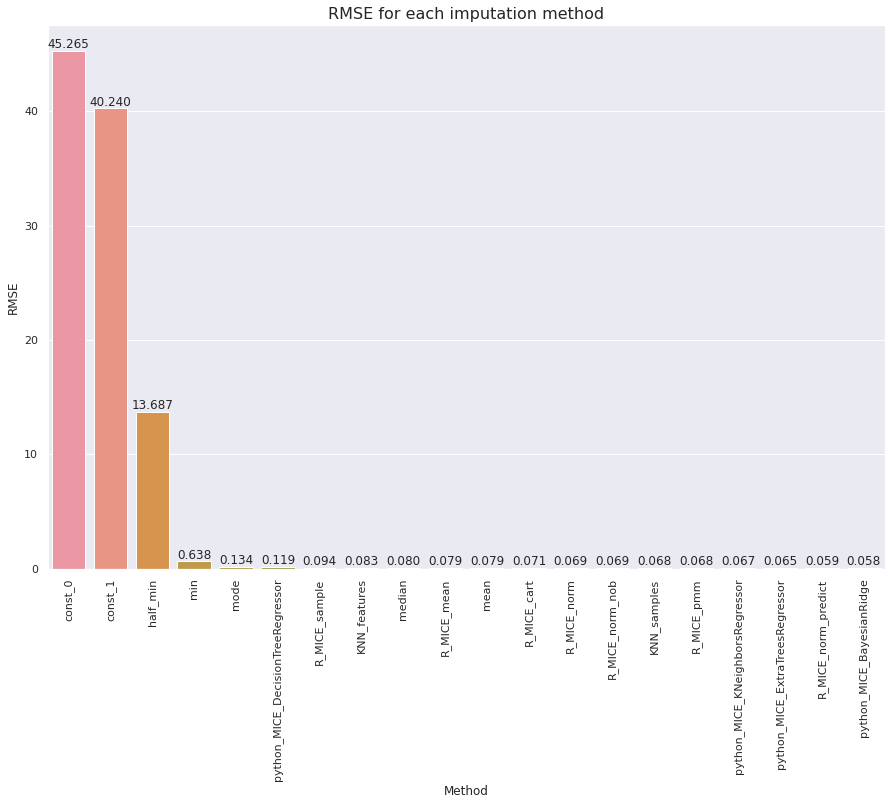

In [261]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(x='Method', y='RMSE', data=df_RMSE);
plt.xticks(rotation=90)
ax.set_title('RMSE for each imputation method', fontsize=16)
ax.bar_label(ax.containers[0], fmt='%.3f');

In [271]:
chosen_imputation_method = df_RMSE["Method"][len(df_RMSE)-1]
print(f'The most suitable method to impute missing data is : {chosen_imputation_method}')

The most suitable method to impute missing data is : python_MICE_BayesianRidge


## Select peak table with most suitable method for further analysis

In [279]:
print(path_peakTable_imputed + 'X_' + chosen_imputation_method + '.csv')

/home/jovyan/work/data/peakTable/imputed_peak_tables/X_python_MICE_BayesianRidge.csv


In [284]:
X_imputed = pd.read_csv(path_peakTable_imputed + 'X_' + chosen_imputation_method + '.csv', sep=',', decimal='.', na_values='NA')
X_imputed

,variable_3,variable_5,variable_6,variable_8,variable_10,variable_11,variable_14,variable_22,variable_23,variable_25,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,19.761786,14.635833,22.185582,12.615143,15.580604,15.881437,17.500899,12.792893,16.805604,16.805842,...,13.194216,12.885181,12.037727,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,19.735279,15.193396,20.831414,12.551386,15.145423,14.034654,17.953780,12.536280,15.907714,14.977232,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,12.082056,12.208084
2,19.116076,15.446714,22.152604,12.513215,14.628890,15.316772,17.404715,12.786407,15.947176,16.238502,...,12.618229,12.485436,11.709115,12.719966,12.578127,12.533468,12.859724,12.118557,12.105708,12.392558
3,19.376875,15.460525,22.169389,12.720767,15.937169,15.967749,15.836957,12.509034,16.371211,17.052231,...,12.720631,12.564338,12.067922,13.397322,12.591688,12.515044,13.086805,12.099655,11.605353,12.319119
4,19.555938,14.515536,22.150249,12.314019,14.950203,15.294906,16.610171,12.214057,16.171763,16.107590,...,12.564943,12.344968,12.127879,12.741220,12.707795,12.508132,12.956176,12.349830,11.926237,12.381520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,19.664978,14.447858,20.808503,12.648327,14.806952,14.244917,17.126579,12.080710,15.388376,15.352711,...,12.533036,12.125251,12.065149,12.686218,12.349299,11.505004,13.189121,11.963865,12.100263,12.301608
182,19.301954,14.839941,21.085175,12.510670,14.488147,15.163197,16.816591,12.452644,16.474456,15.953391,...,13.428278,12.629126,12.360380,12.410226,12.909283,12.642143,12.631445,12.708850,12.462751,12.635066
183,19.170626,14.291711,21.381912,12.499558,14.434959,14.520558,16.315887,12.808417,15.613263,15.522875,...,13.213899,12.799193,11.870228,12.680070,12.846355,13.243400,13.001685,12.199647,12.074455,12.258149
184,18.869505,14.440576,20.961485,12.312338,14.114074,13.776358,16.110117,12.667428,16.021372,14.859646,...,12.442173,12.291946,12.035968,12.554394,12.477753,11.789382,12.940688,11.628154,12.117310,12.265073


In [287]:
peakTable_imputed = pd.concat([metadata, X_imputed], axis=1)
peakTable_imputed

,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,variable_3,variable_5,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,19.761786,14.635833,...,13.194216,12.885181,12.037727,13.330208,12.052252,12.568647,13.192848,12.248590,12.114328,12.355017
1,LivCan_154,Non-case,82,NaN,No,41____41046868,41____41046868,41046868-s2#C,19.735279,15.193396,...,12.700734,12.742979,11.929552,13.464403,13.020365,12.928643,13.697314,12.604052,12.082056,12.208084
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,19.116076,15.446714,...,12.618229,12.485436,11.709115,12.719966,12.578127,12.533468,12.859724,12.118557,12.105708,12.392558
3,LivCan_268,Non-case,427,NaN,No,41____41089214,41____41089214,41089214-s1#B,19.376875,15.460525,...,12.720631,12.564338,12.067922,13.397322,12.591688,12.515044,13.086805,12.099655,11.605353,12.319119
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,19.555938,14.515536,...,12.564943,12.344968,12.127879,12.741220,12.707795,12.508132,12.956176,12.349830,11.926237,12.381520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,NaN,No,32____3208004E,32____32253231,32253231-s3#C,19.664978,14.447858,...,12.533036,12.125251,12.065149,12.686218,12.349299,11.505004,13.189121,11.963865,12.100263,12.301608
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,19.301954,14.839941,...,13.428278,12.629126,12.360380,12.410226,12.909283,12.642143,12.631445,12.708850,12.462751,12.635066
183,LivCan_376,Non-case,383,NaN,No,22____22281701,22____22281701,22281701-s1#B,19.170626,14.291711,...,13.213899,12.799193,11.870228,12.680070,12.846355,13.243400,13.001685,12.199647,12.074455,12.258149
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,18.869505,14.440576,...,12.442173,12.291946,12.035968,12.554394,12.477753,11.789382,12.940688,11.628154,12.117310,12.265073


## For the next notebook, the imputed peak table right above should be used ! We save it in a separate folder

In [292]:
peakTable_imputed.to_csv(pwd + 'data/peakTable/chosen_imputed_peakTable/' + 'peakTable_imputed-' + chosen_imputation_method + '.csv', header=True, index=False)